In [1]:
import os
import torch
import random
import torch.nn as nn
import torch.backends.cudnn as cudnn
import numpy as np
from models import build_model
from PIL import Image

#### Building the LaVIT Model and Load the checkpoint

In [2]:
# The local directory to save LaVIT checkpoint
model_path='/home/jinyang06/models/LaVIT_LLaMA2'
model_dtype='bf16'

seed = 1234
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Set the load GPU id
device_id = 0
torch.cuda.set_device(device_id)
device = torch.device('cuda')

# For Text-to-Image Generation, set `load_tokenizer=False` to save the GPU memory
# If you have already install xformers, set `use_xformers=True` to save the GPU memory (Xformers is not supported on V100 GPU)
# If you have already download the checkpoint, set `local_files_only=True`` to avoid auto-downloading from remote
model = build_model(model_path=model_path, model_dtype=model_dtype, check_safety=False,
            device_id=device_id, use_xformers=True, understanding=False, load_tokenizer=False)
model = model.to(device)    
print("Building Model Finsished")
torch_dtype = torch.bfloat16 if model_dtype=="bf16" else torch.float16

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. If you see this, DO NOT PANIC! This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Loading LaVIT Model Weight from /home/jinyang06/models/LaVIT_LLaMA2, model precision: bf16


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Load visual tokenizer decoder weight from /home/jinyang06/models/LaVIT_LLaMA2/visual_tokenizer/highres_tokenizer_decoder.bin
You are using XFormers ops, please make sure your device install and support xformers
Building Model Finsished


#### Text-to-Image Synthesis

100%|██████████| 50/50 [00:07<00:00,  6.81it/s]


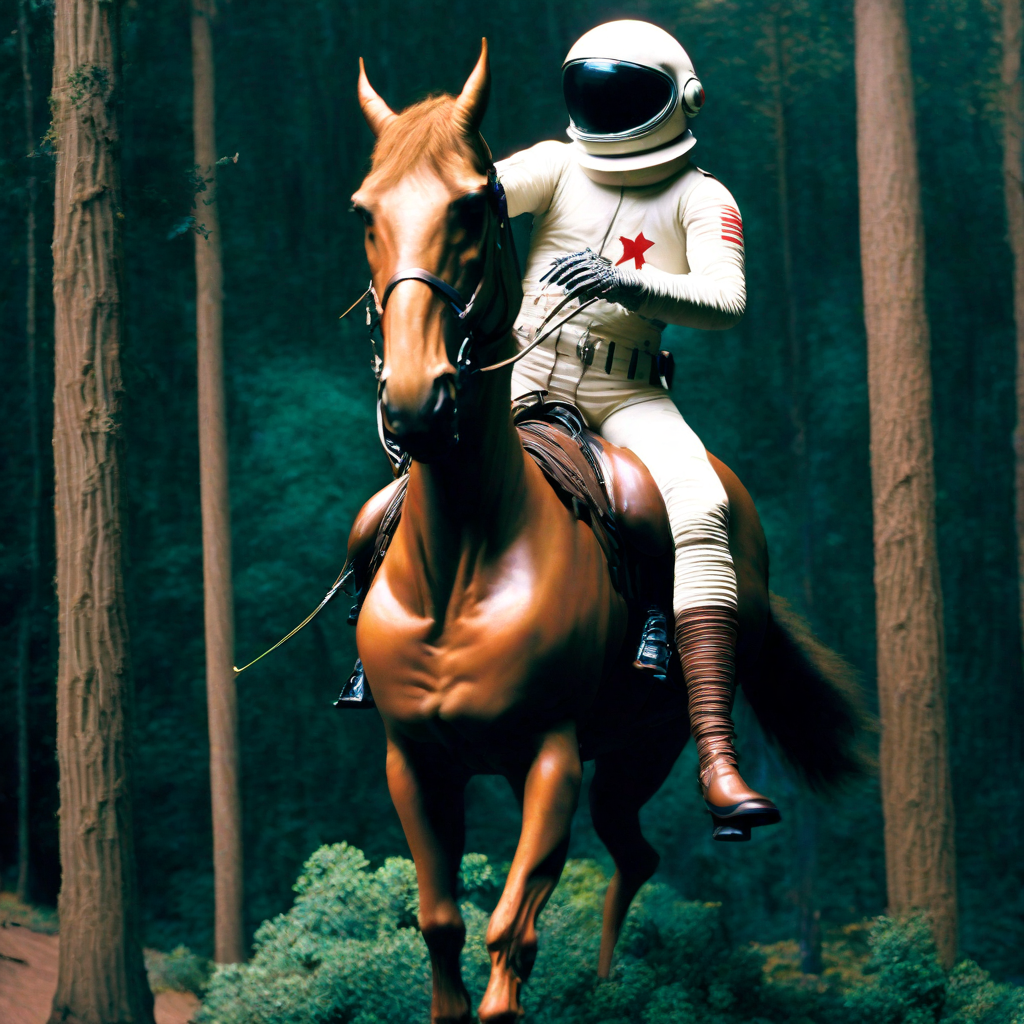

In [4]:
# Text-to-Image Generation

prompt = "A photo of an astronaut riding a horse in the forest."
# prompt = "A high contrast photo of panda dressed as an astronaut sits at a table in a photorealistic style"
# prompt = "a sculpture of a duck made of wool"
# prompt = "A small cactus wearing a straw hat and neon sunglasses in the Sahara desert."
# prompt = "Cute adorable little goat, unreal engine, cozy interior lighting, art station, detailed digital painting, cinematic, octane rendering"
# prompt = 'a super math wizard cat, richly textured oil painting'
# prompt = "A squirrel gives an apple to a bird"
# prompt = 'A photograph of a bird wearing headphones and speaking into a high-end microphone in a recording studio.'
# prompt = "A blue jay standing on a large basket of rainbow macarons"
# prompt = "A photo of a light bulb in outer space traveling the galaxy with a sailing boat inside the light bulb"
# prompt = "A large cabin on top of a sunny mountain"
# prompt = "A oil painting of a female painter with a brush in hand, white background, painting, looking very powerful"
# prompt = "A richly textured oil painting of a young badger delicately sniffing a yellow rose next to a tree trunk. A small waterfall can be seen in the background."
# prompt = "A photo of a Corgi dog riding a bike in Times Square, it is wearing sunglasses"
# prompt = "A monkey with a glasses sitting on a rock"


# LaVIT support 6 different image aspect ratios
ratio_dict = {
    '1:1' : (1024, 1024),
    '4:3' : (896, 1152),
    '3:2' : (832, 1216),
    '16:9' : (768, 1344),
    '2:3' : (1216, 832),
    '3:4' : (1152, 896),
}

# The image aspect ratio you want to generate
ratio = '1:1'
height, width = ratio_dict[ratio]

with torch.cuda.amp.autocast(enabled=True, dtype=torch_dtype):
    images = model.generate_image(prompt, width=width, height=height, num_return_images=1, 
        guidance_scale_for_llm=4.0, num_inference_steps=25, top_k=50)

display(images[0])
images[0].save('output/t2i_output.jpg')